In [1]:
# https://www.kaggle.com/dlarionov/feature-engineering-xgboost
# https://dacon.io/competitions/official/235584/codeshare/1047?page=1&dtype=recent

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## font
import matplotlib as mpl
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

## time
from datetime import datetime,timedelta

In [89]:
base='2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/'
train_folder='01_제공데이터/'

data=pd.read_excel(base+train_folder+'2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx')

In [90]:
cols=['홍수사상번호','연','월','일','시간','유입량']

for i in range(1,7):
    prefix=f'데이터집단{i}_'
    cols.append(prefix+'유역평균강수')
    cols.append(prefix+'강우(A지역)')
    cols.append(prefix+'강우(B지역)')
    cols.append(prefix+'강우(C지역)')
    cols.append(prefix+'강우(D지역)')
    cols.append(prefix+'수위(E지역)')
    cols.append(prefix+'수위(B지역)')

In [91]:
data=data.drop(0)
data.columns=cols

In [92]:
valid=data[data['유입량'].isnull()].drop(['유입량'],axis=1)
data=data.drop(valid.index)

In [93]:
# https://ichi.pro/ko/python-ui-gogeub-sigyeyeol-bunseog-bunhae-jagi-sang-gwan-19081034942302

# 계절성,추세,노이즈 를 분석
# 여러 시계열을 동시에 분석 및 비교
# 자기상관 및 부분 자기상관 계산 및 해석

In [94]:
# 지역(A,B,C,D,R)별 (데이터 집단 간)차이 알아보기
# 기술 통계량 확인
# 1시간,2시간 후 와의 차이 보기
# 시간 별 유입량으로 시간의 특징 보기

# 논문에서 기상인자, 자기상관함수, 교차상관함수를 통한 지연된 댐 유입량.
# 기상인자는 지역에 대한 정보가 없어 x.
# 자기상관함수 또한 끊긴 정보로 x.

In [95]:
for idx,col in enumerate(cols):
    if idx<5:
        data[col]=data[col].astype(int)
    else:
        data[col]=data[col].astype(float)    

In [96]:
data['time']=data.apply(lambda row:datetime(year=int(row['연']),month=int(row['월']),day=int(row['일'])),axis=1)
data['time']=data.apply(lambda row:row['time']+timedelta(hours=row['시간']),axis=1)

In [97]:
data=data.set_index('time')

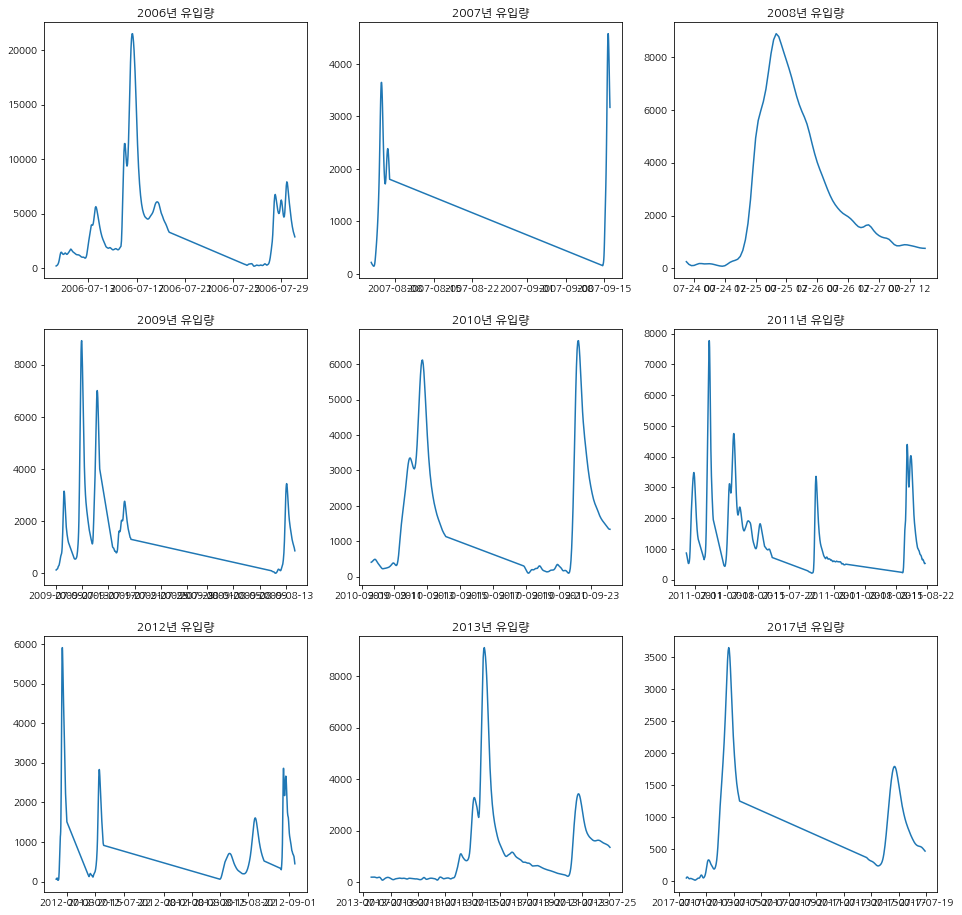

In [98]:
## 중간중간 끊기는 점들은 데이터가 없는 경우.
## 즉, 이어져있지않다.

## 

fig,ax=plt.subplots(3,3,figsize=(16,16))

ax[0][0].plot(data[data['연']==2006]['유입량'])
ax[0][0].set_title('2006년 유입량')

ax[0][1].plot(data[data['연']==2007]['유입량'])
ax[0][1].set_title('2007년 유입량')

ax[0][2].plot(data[data['연']==2008]['유입량'])
ax[0][2].set_title('2008년 유입량')

ax[1][0].plot(data[data['연']==2009]['유입량'])
ax[1][0].set_title('2009년 유입량')

ax[1][1].plot(data[data['연']==2010]['유입량'])
ax[1][1].set_title('2010년 유입량')

ax[1][2].plot(data[data['연']==2011]['유입량'])
ax[1][2].set_title('2011년 유입량')

ax[2][0].plot(data[data['연']==2012]['유입량'])
ax[2][0].set_title('2012년 유입량')

ax[2][1].plot(data[data['연']==2013]['유입량'])
ax[2][1].set_title('2013년 유입량')

ax[2][2].plot(data[data['연']==2017]['유입량'])
ax[2][2].set_title('2017년 유입량')

plt.show()

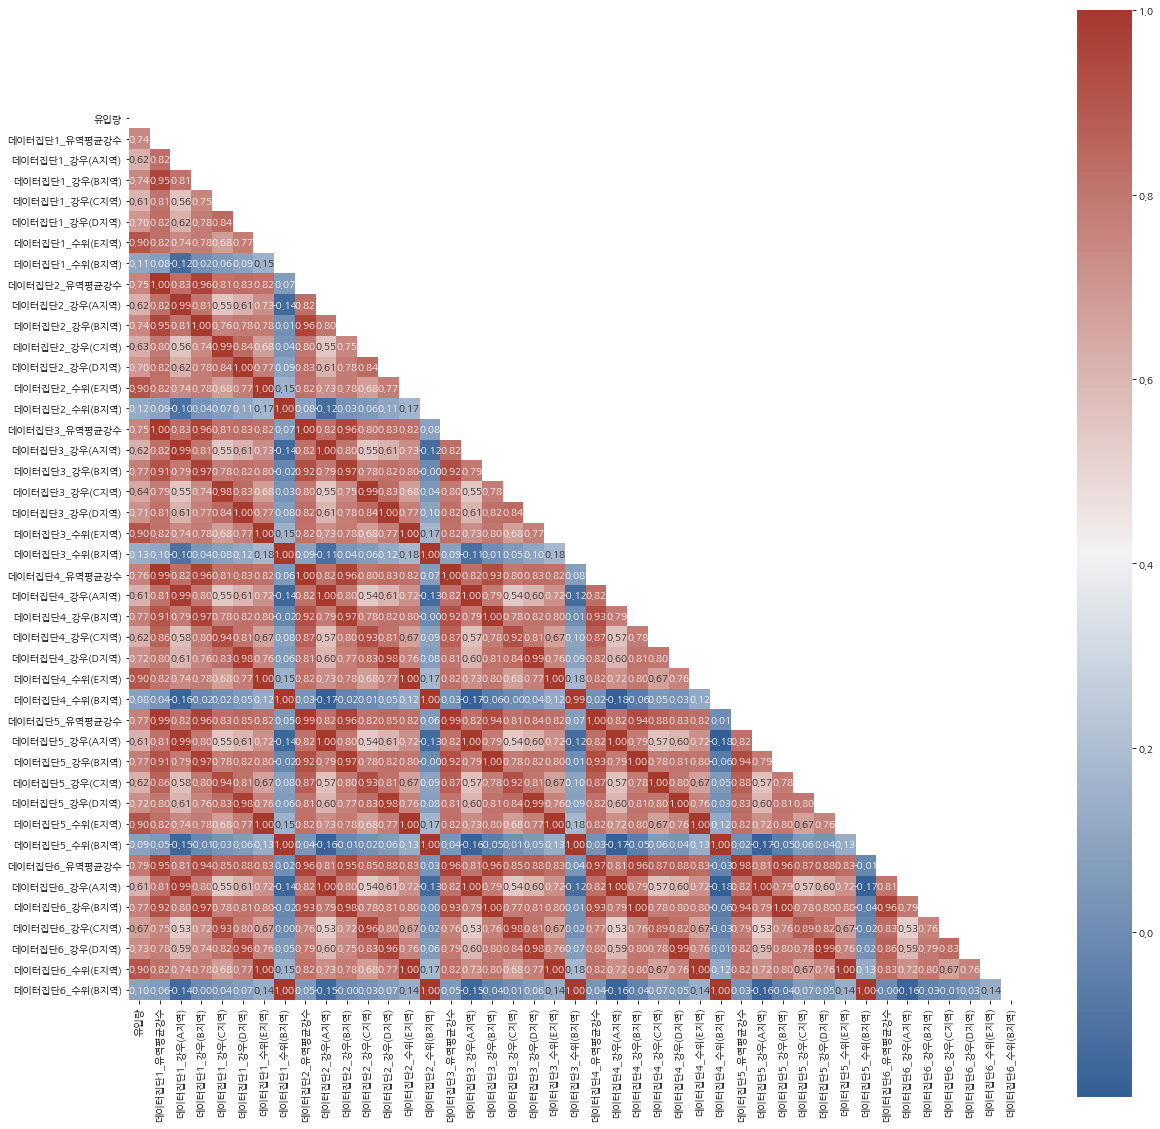

In [99]:
## 저번에 말했던 데이터지역들의 수위(E지역)은 모두 같다.

cmap=sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
matrix=data.iloc[:,5:].corr(method='pearson')
mask=np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show()

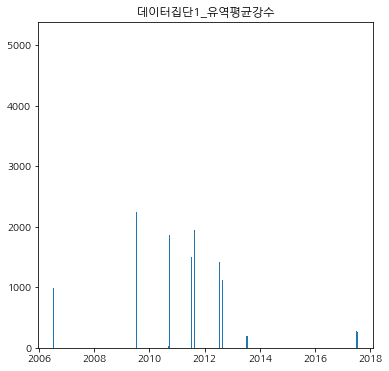

In [100]:
normalized=data.iloc[:,6:].div(data.iloc[:,6:].iloc[0]).mul(100)

fig,ax=plt.subplots(1,1,figsize=(6,6))

ax.bar(x=normalized.index,height=normalized['데이터집단1_유역평균강수'])
ax.set_title('데이터집단1_유역평균강수')

plt.show()

In [101]:
## 시계열 분해가 안된다. 
## 뚝뚝 끊겨있어 freq 가 정의가 안되어있다.

## 시계열이 아닌 독립적인 행들로 모델을 만든다고 생각한다. 즉, 회귀 혹은 tree계열
## 혹은 인공신경망. 실제로 논문에 인공신경망을 많이 사용했다.

# import statsmodels.api as sm

# decompose_=sm.tsa.seasonal_decompose(data["데이터집단1_유역평균강수"])
# decompose.plot()

# def autocorr(x, t=1):
#     return np.corrcoef(np.array([x[:-t], x[t:]]))

# autocorr(data['데이터집단1_유역평균강수'],1)

In [102]:
## 자기상관함수의 역할은 자기 자신은 시차를 두고 관계가진다는 것.
## 끊겼지만, 그리고 자기상관함수를 적용할 수는 없지만, 가정을 하고 (-1,-2) lag변수를 만들어서 적용.

# np.corrcoef(data['데이터집단1_유역평균강수'].iloc[:-1],data['데이터집단1_유역평균강수'].shift(-1).iloc[:-1])
## 0.99

# data['데이터집단1_유역평균강수'].iloc[:-1].autocorr(lag=-1020)

In [103]:
groupdata=data.groupby(['연','월','시간'])[data.columns[5:]].mean()
groupdata=groupdata.reset_index()

In [145]:
## 20번까지 해봤는데 10번 안에서 하는게 괜찮다.

def get_cluster(year,df):
    sub=df[df['연']==year]

    fig,ax=plt.subplots(3,1,figsize=(16,30))
    
    # basic
#     for col in sub.columns[4:]:
#         ax[0].plot(sub[col],label=col)

#     plt.legend()
#     plt.show()
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    seed=0
    K_values = range(1,10)   # we will test different numbers of clusters K = {1,...,9}
    models=[]; preds=[]; inertias=[]; silhouettes=[]

    X=df.iloc[:,4:].values.T

    for i in K_values:
        models.append( KMeans(n_clusters=i,
                              init='k-means++',
                              n_init=10,
                              max_iter=300,
                              tol=0.0001,
    #                           precompute_distances='auto',
                              verbose=0,
                              random_state=seed,
                              copy_x=True,
    #                           n_jobs=None,
                              algorithm='auto') )
        models[i-1].fit(X)
        preds.append( models[i-1].predict(X) )
        inertias.append( models[i-1].inertia_ )   # inertia is the sum of squared distances from data points to their centroid
        silhouettes.append( silhouette_score(X,preds[i-1]) ) if i>1 else silhouettes.append(0)
        # centroids.append( models[i-1].cluster_centers_ )
        print(preds[i-1],'  ',i,'cluster ' if i==1 else 'clusters',
              '  inertia:', inertias[i-1],
              '  silhouette:', silhouettes[i-1])

    ax[0].plot(K_values, inertias)
    ax[0].set_xlabel('n clusters')
    ax[0].set_title('Inertia')
        
    ax[1].plot(K_values, silhouettes)
    ax[1].set_xlabel('n clusters')
    ax[1].set_title('Silhouette Score')
    
    idx=np.argmax(silhouettes)
    if idx==3:
        color={2:'b',0:'g',1:'r'}
    elif idx==4:
        color={2:'b',0:'g',1:'r',3:'c'}
    elif idx==5:
        color={2:'b',0:'g',1:'r',3:'c',4:'m'}
    elif idx==6:
        color={2:'b',0:'g',1:'r',3:'c',4:'m',5:'y'}
    elif idx==7:
        color={2:'b',0:'g',1:'r',3:'c',4:'m',5:'y',6:'k'}
    elif idx==8:
        color={2:'b',0:'g',1:'r',3:'c',4:'m',5:'y',6:'k',7:'tab:orange'}
    elif idx==9:
        color={2:'b',0:'g',1:'r',3:'c',4:'m',5:'y',6:'k',7:'tab:orange',8:'tab:blue'}
        
    # c cyan 형광, m magenta 자홍. k는 black 
    cls=models[idx-1].predict(X)

    rep=pd.DataFrame({'col':df.columns[4:],'color':cls})
    
    for col,clss in zip(sub.columns[4:],cls):
        ax[2].plot(sub[col],label=col,color=color[clss])

    plt.legend()
    plt.show()
    
    return rep

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

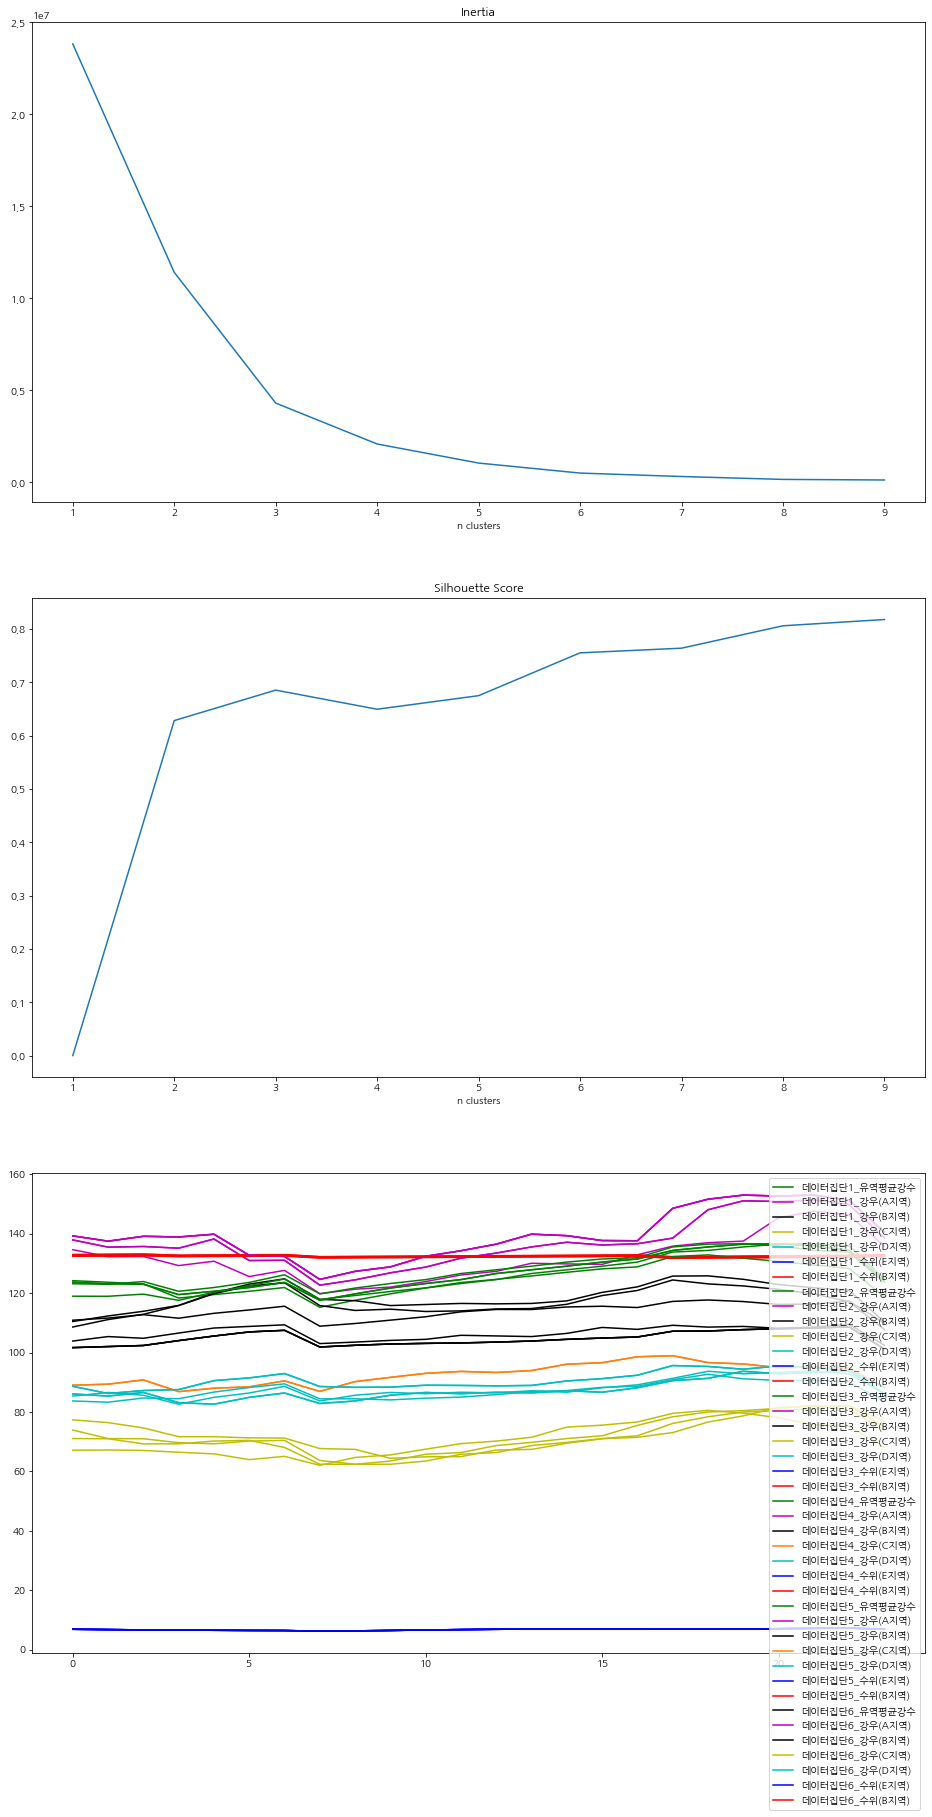

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

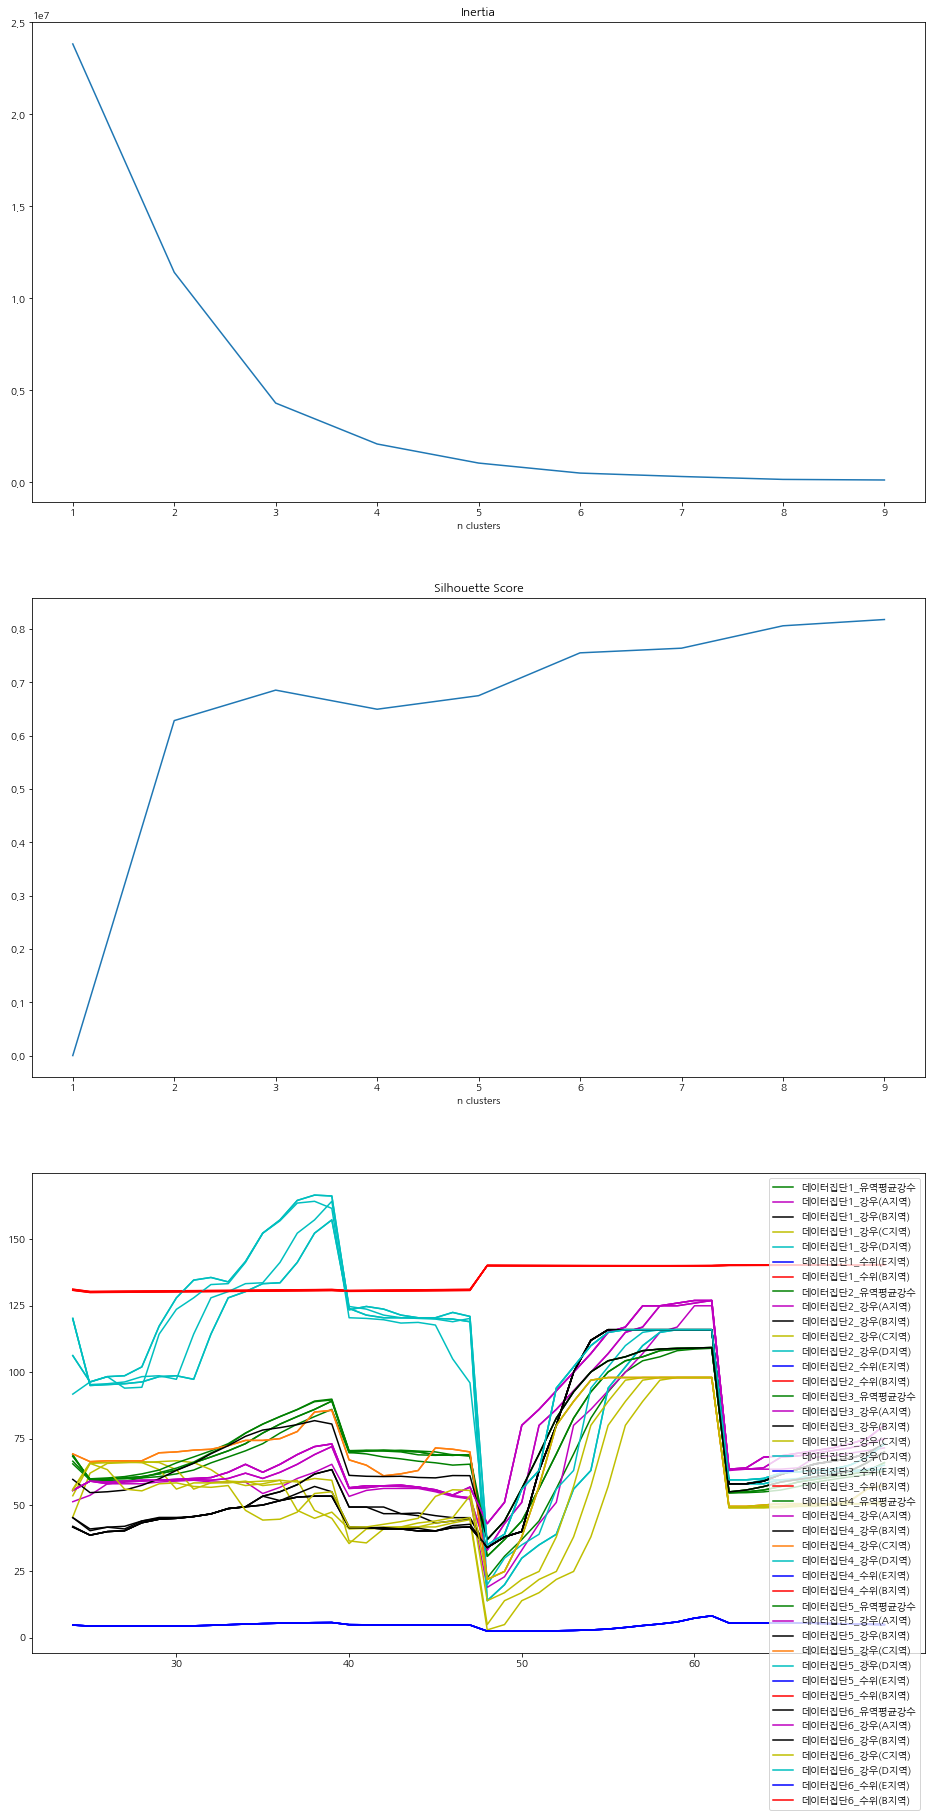

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

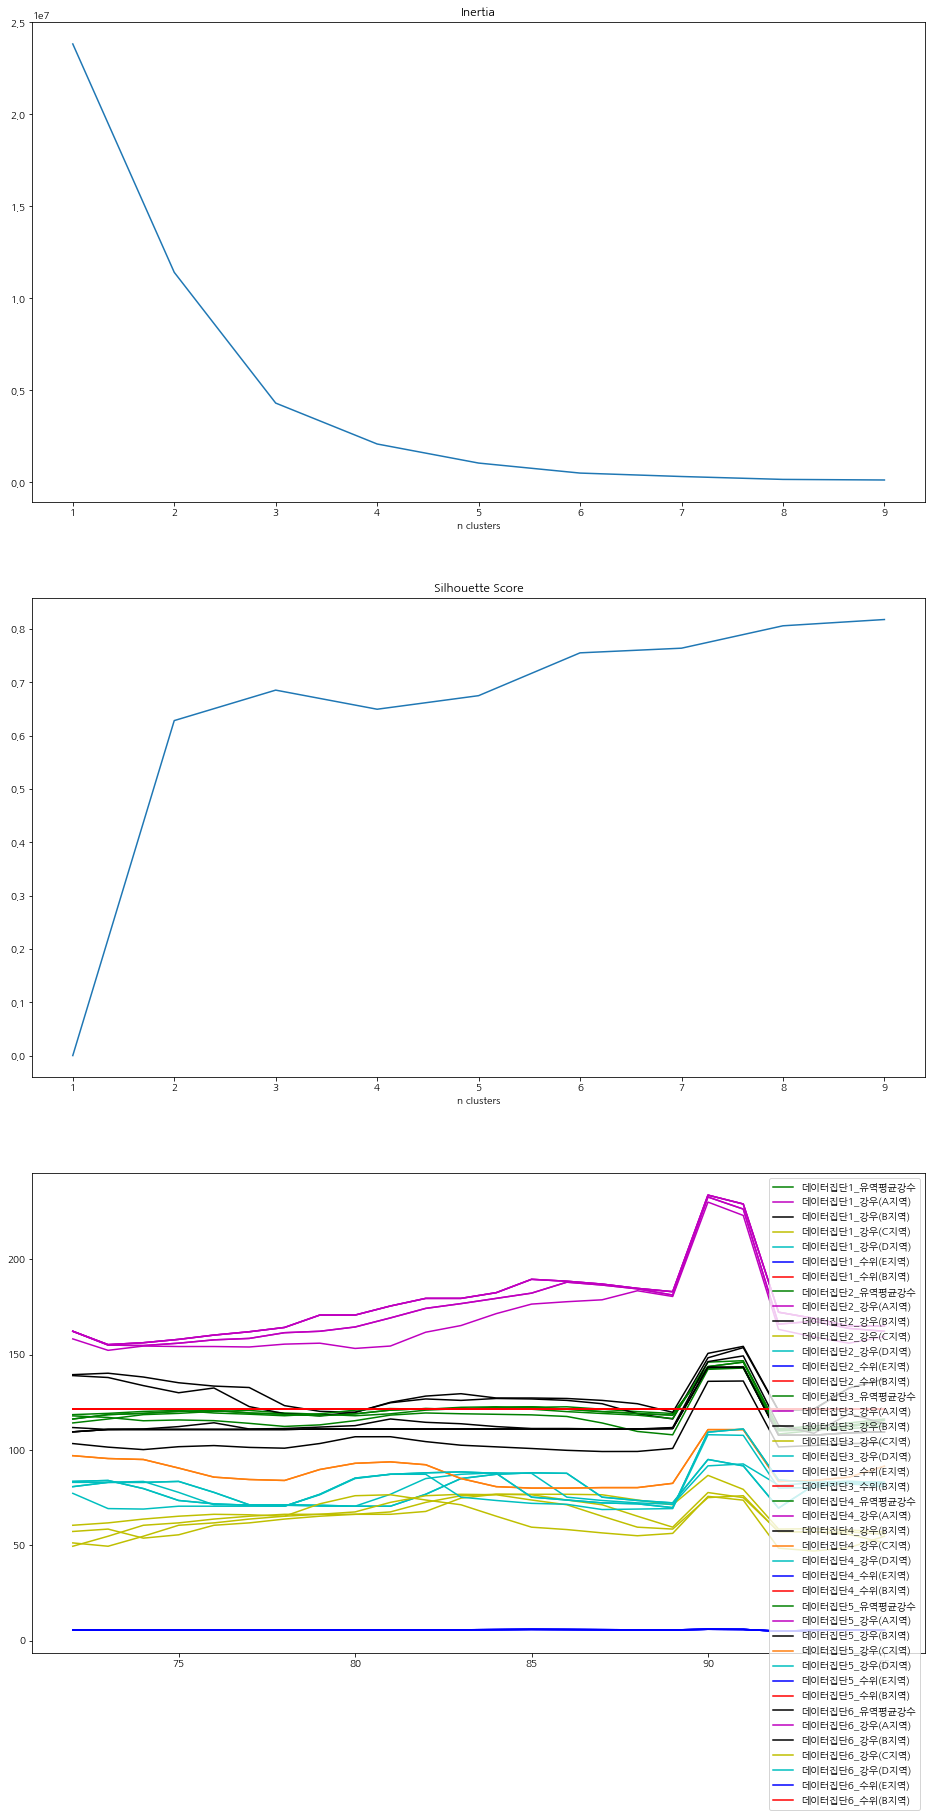

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

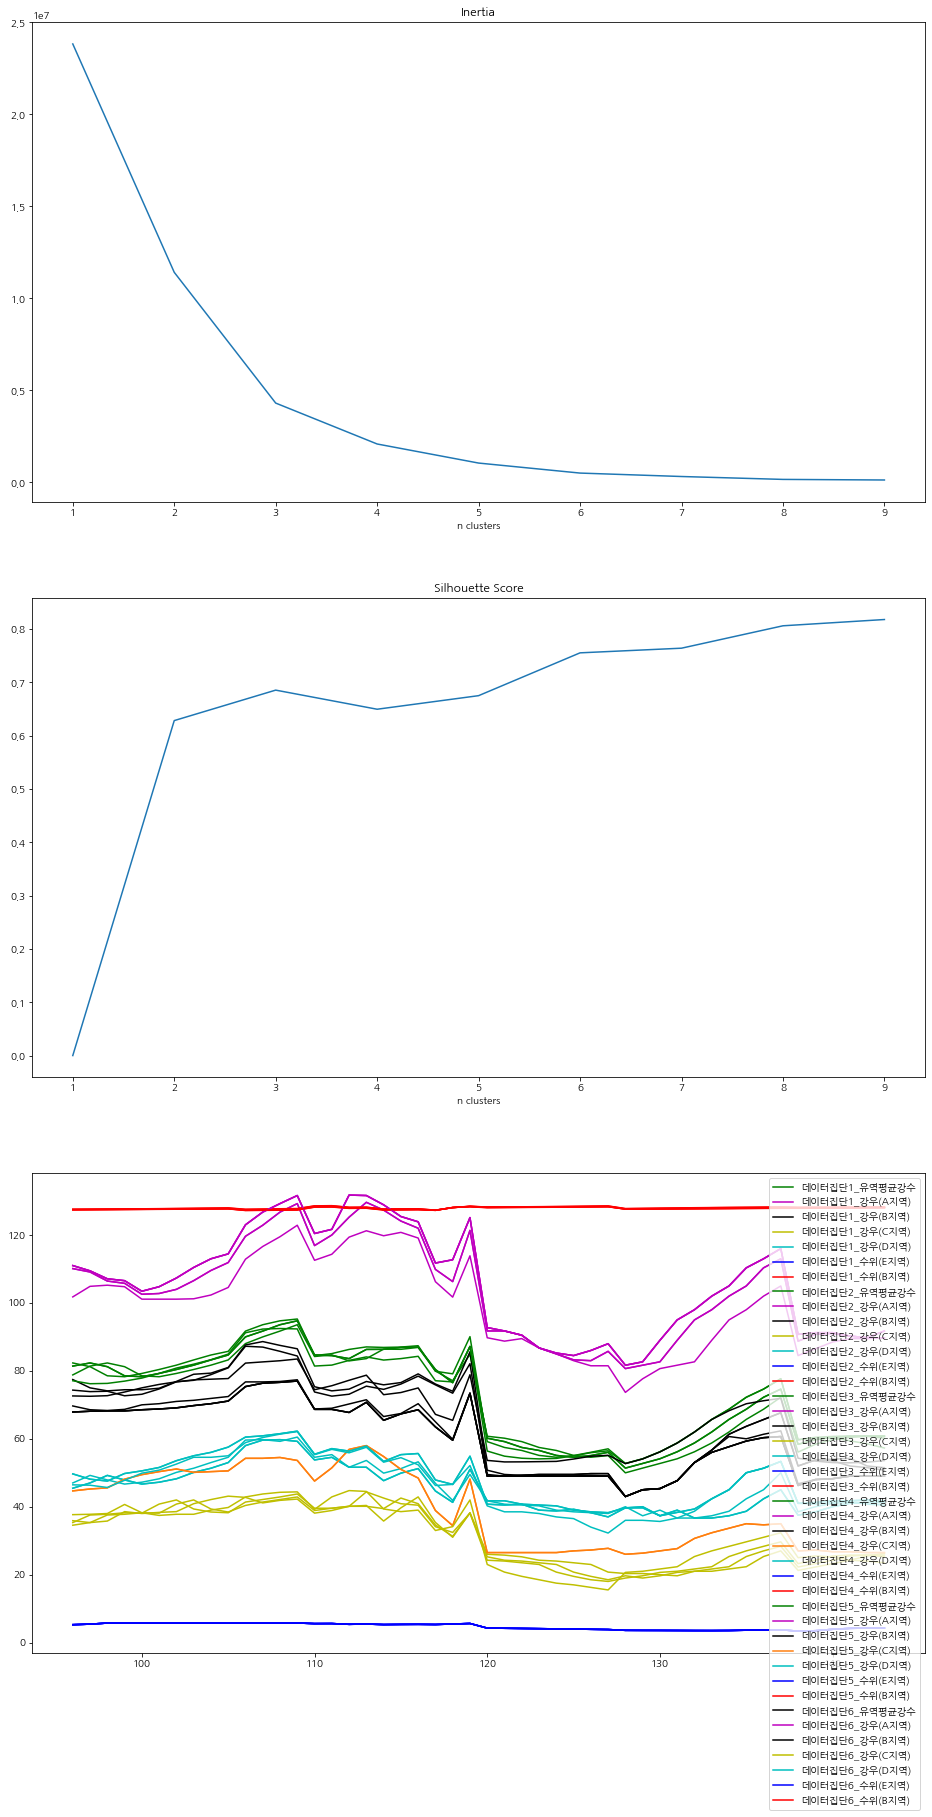

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

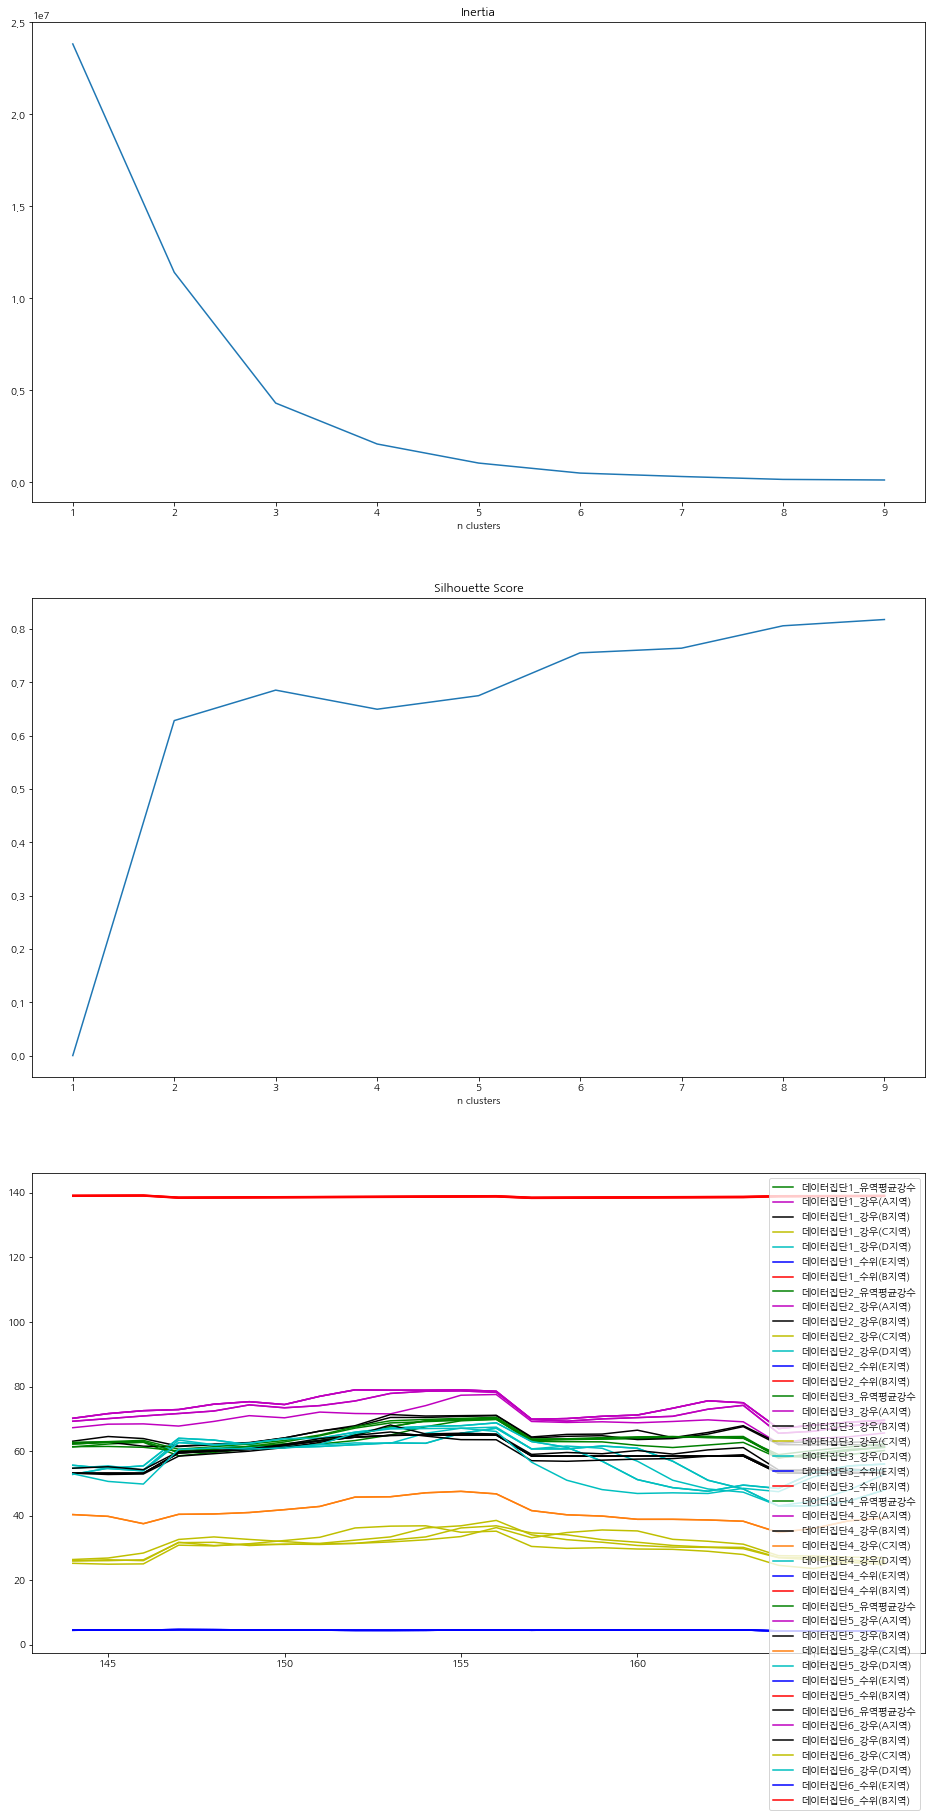

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

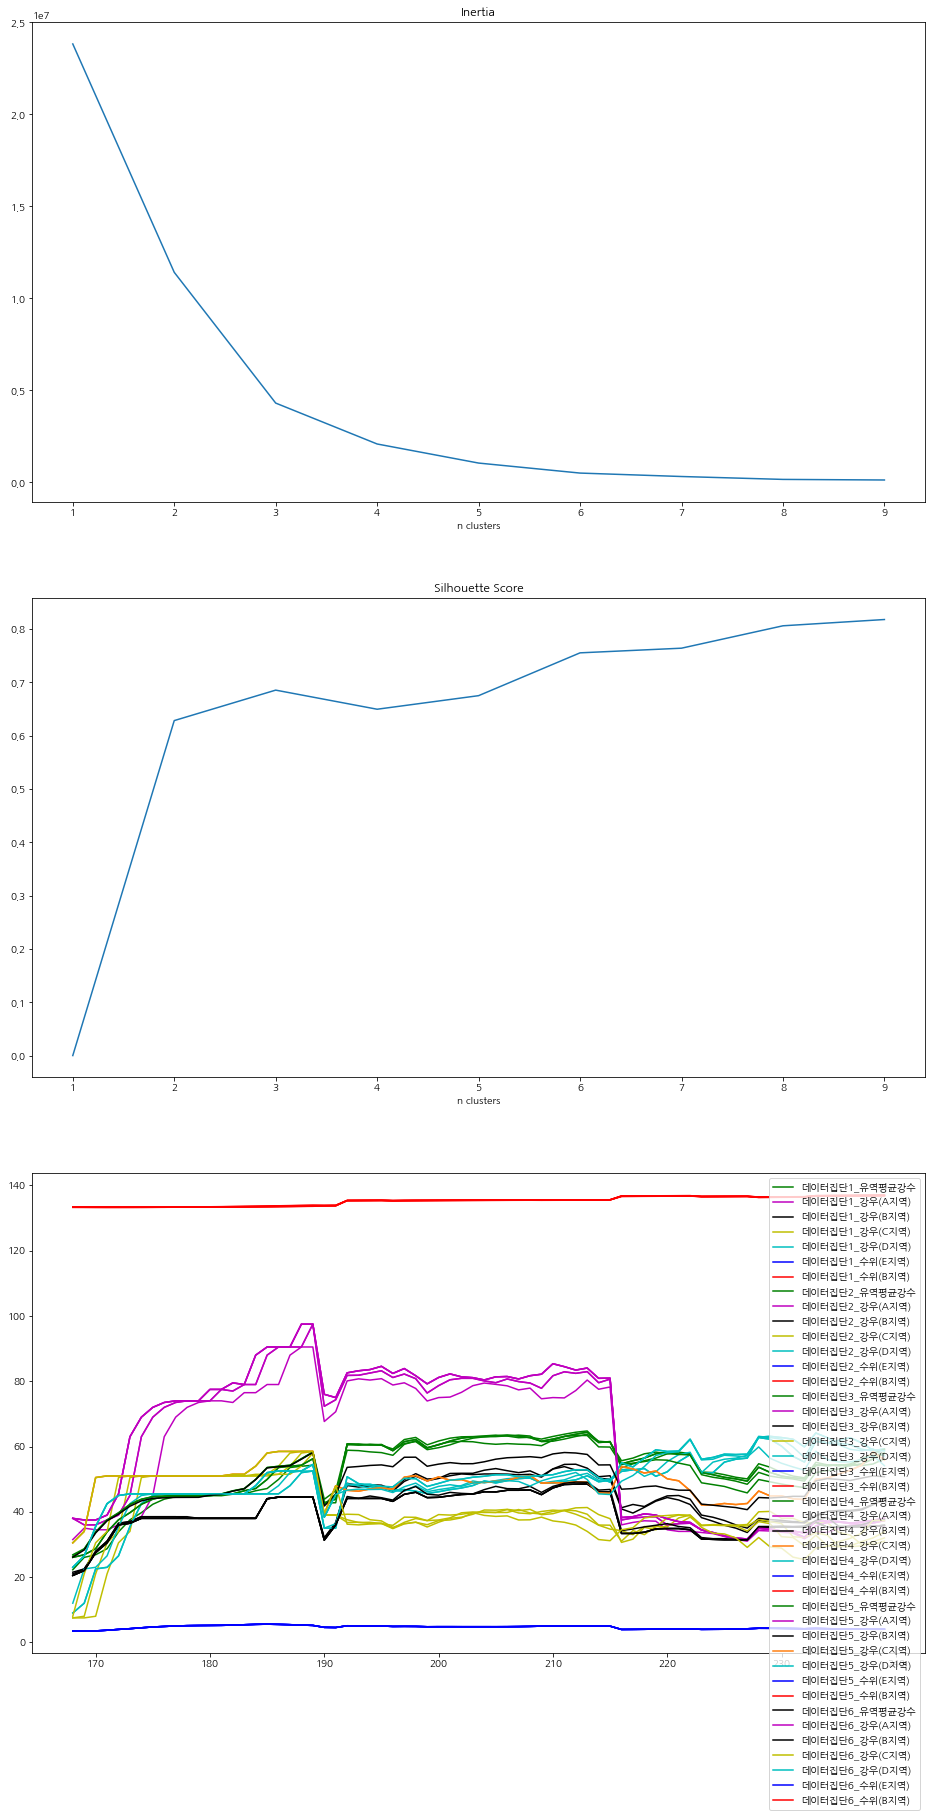

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

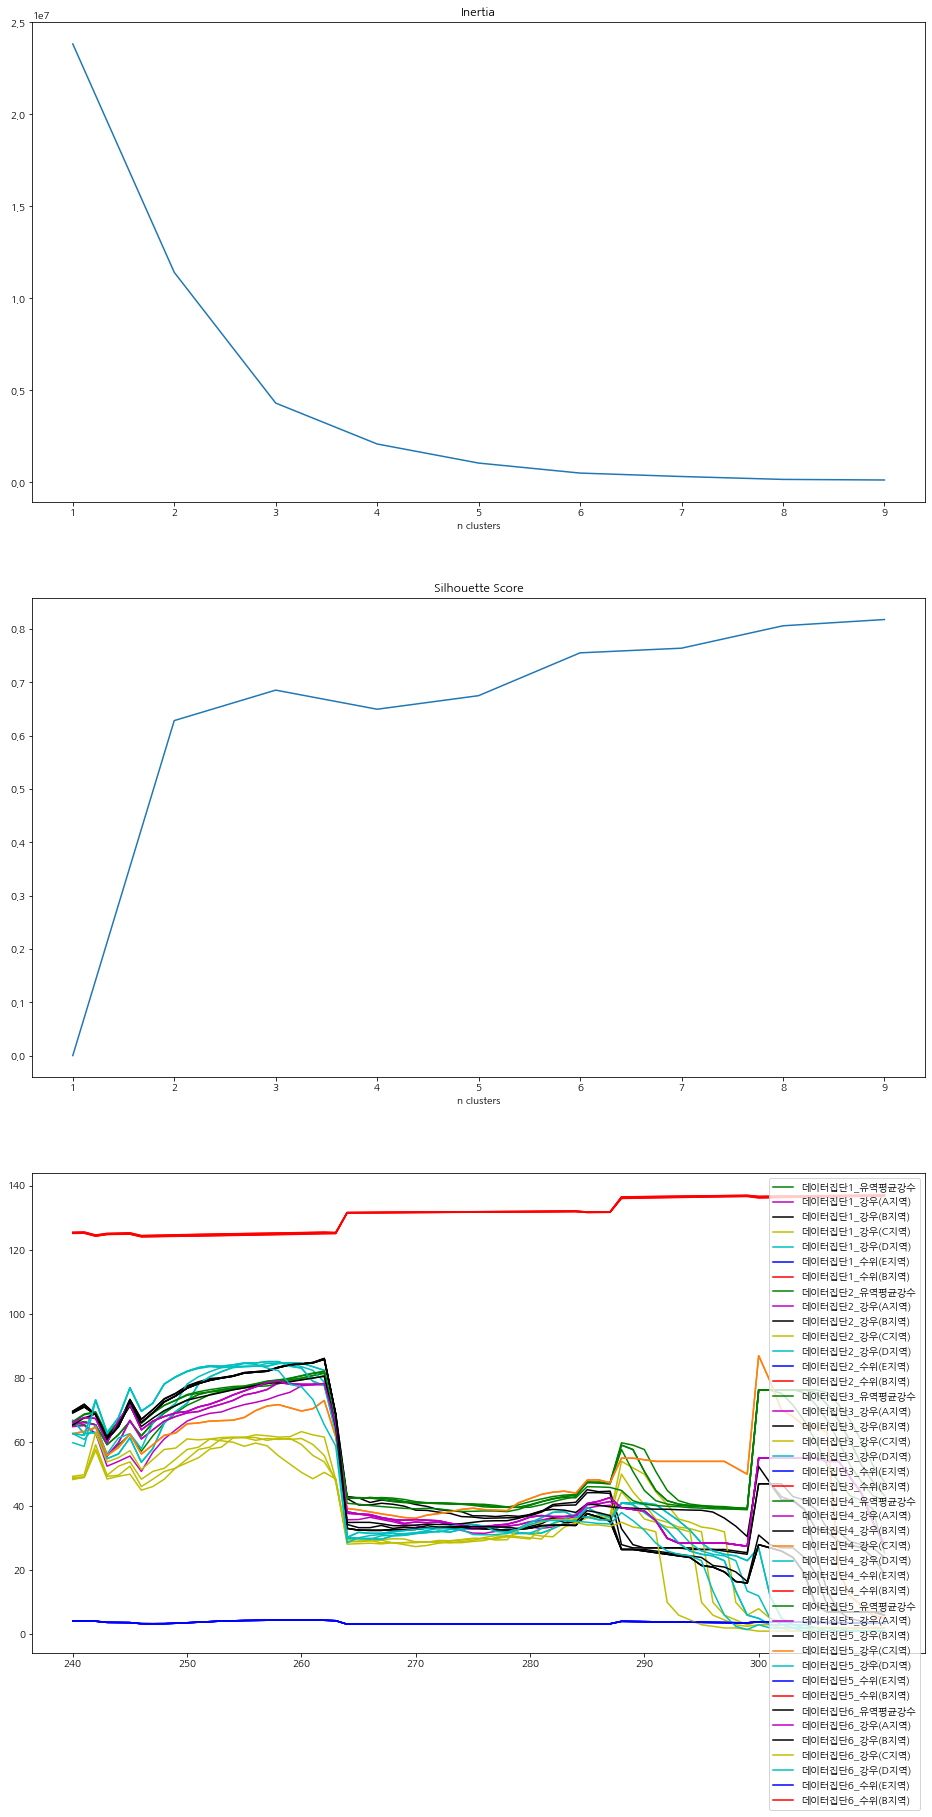

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

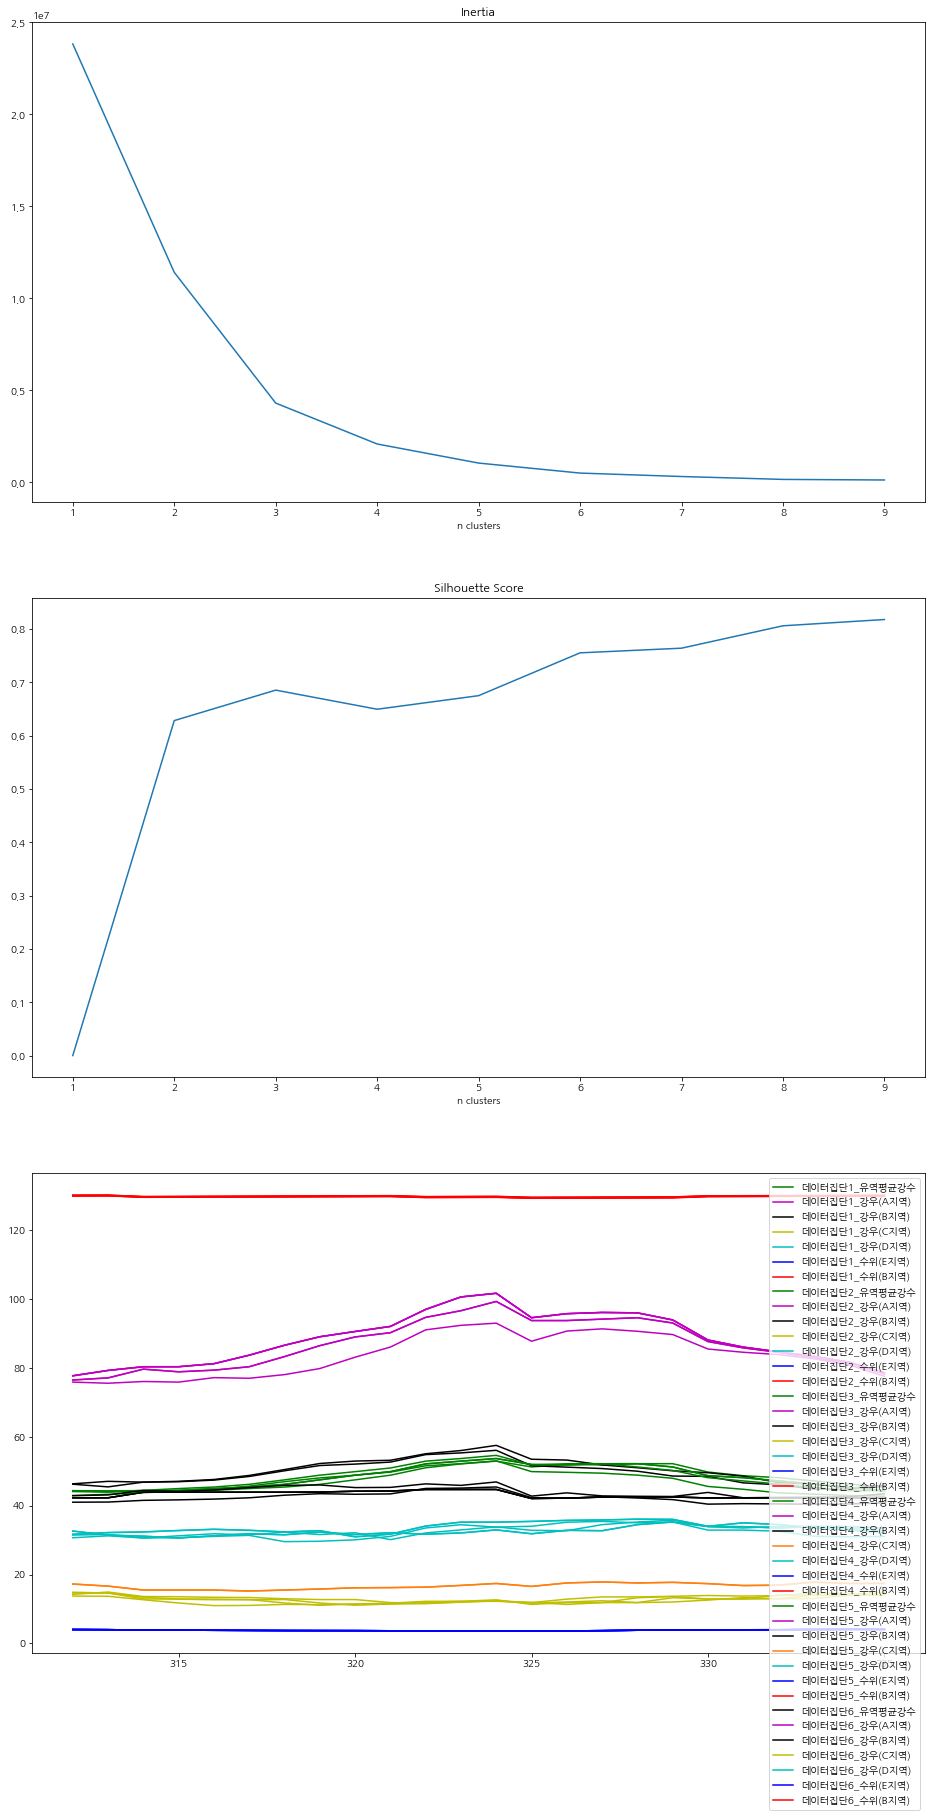

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]    1 cluster    inertia: 23817020.73350617   silhouette: 0
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1]    2 clusters   inertia: 11402812.687726898   silhouette: 0.6280113940900833
[0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 0 2 1]    3 clusters   inertia: 4294286.109920222   silhouette: 0.6851366766606632
[0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3 0 0 0 2 1 0 3
 0 0 0 2 1]    4 clusters   inertia: 2070026.4640494913   silhouette: 0.6493141821497028
[4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3 4 0 0 2 1 4 3
 4 0 0 2 1]    5 clusters   inertia: 1033378.053044312   silhouette: 0.6747510045134055
[0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4 0 5 3 2 1 0 4
 0 5 3 2 1]    6 clusters   inertia: 488922.7625020181   silhouette: 0.7550258916577466
[0 4 6 5 3 2 1 0 4 6 5 3 2 1 0 4 6 5 

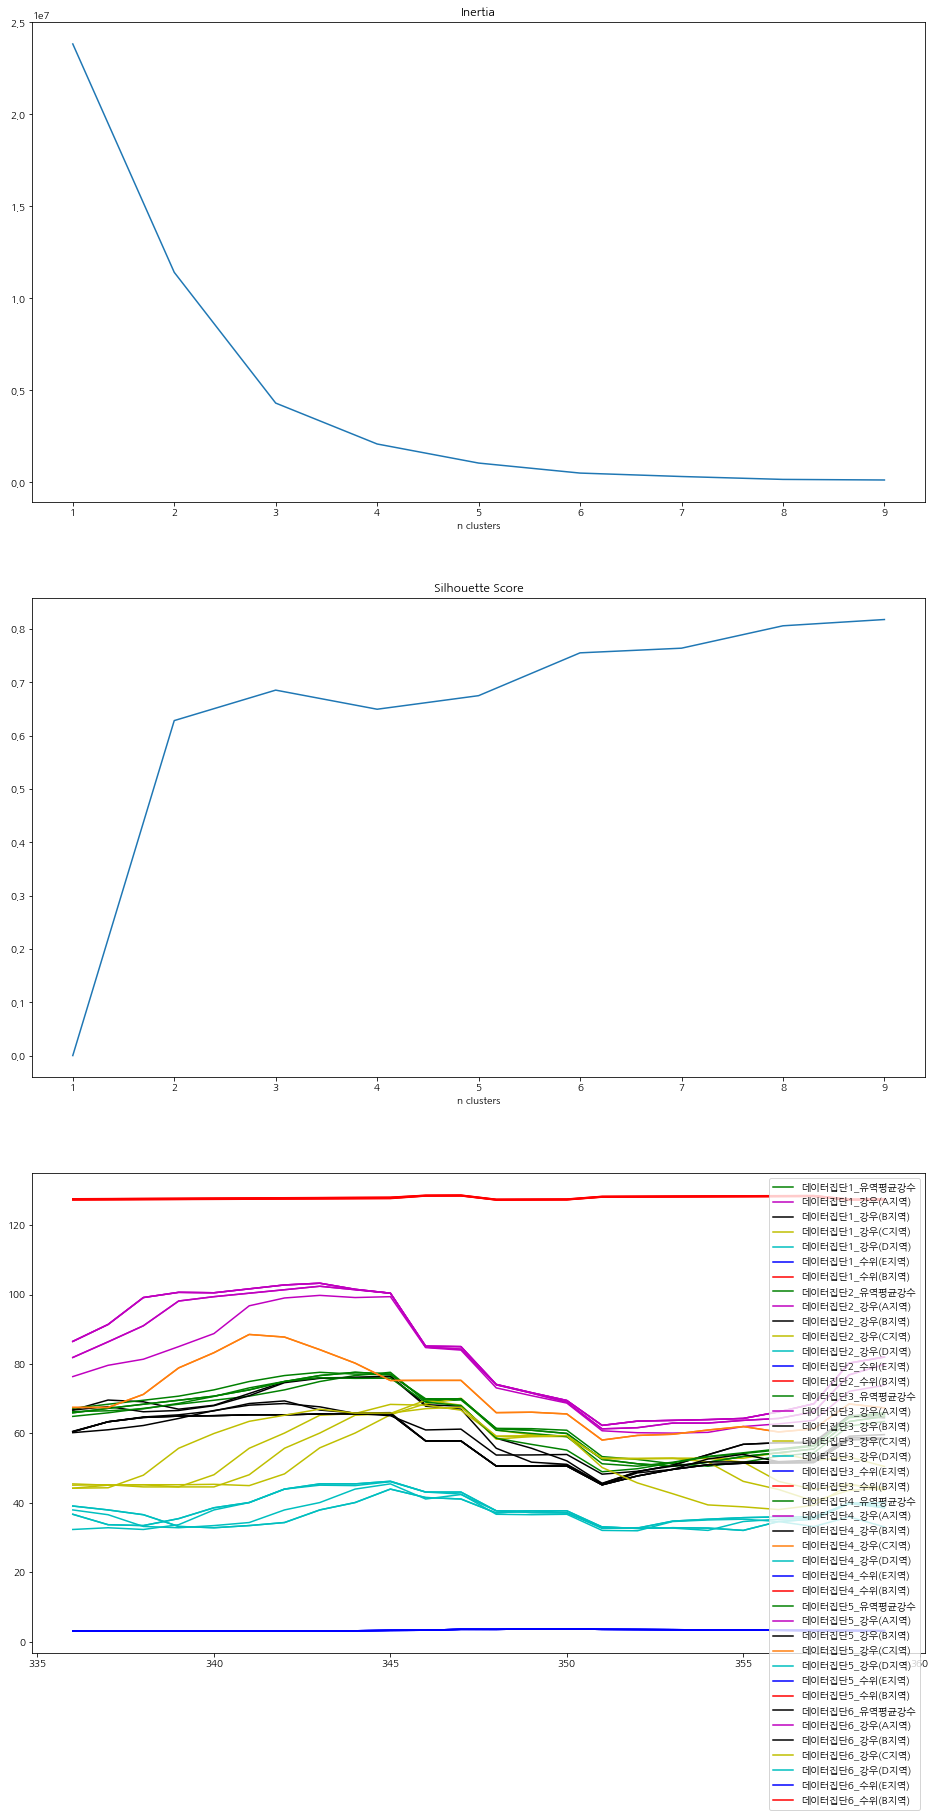

In [147]:
rep2006=get_cluster(2006,groupdata)
rep2007=get_cluster(2007,groupdata)
rep2008=get_cluster(2008,groupdata)
rep2009=get_cluster(2009,groupdata)
rep2010=get_cluster(2010,groupdata)
rep2011=get_cluster(2011,groupdata)
rep2012=get_cluster(2012,groupdata)
rep2013=get_cluster(2013,groupdata)
rep2017=get_cluster(2017,groupdata)

In [237]:
# 2006년

# 1,2,3,4,5 유역평균강수가 비슷하다.
# 1,2,3,4,5,6 수위b지역이 비슷하다.
# 1,2,3,4,5,6 수위e지역이 비슷하다. 
# 1,2,3,4,5,6 강우 d지역이 비슷하다.
# 1,2,3,4,5,6 강우 a지역이 비슷하다.
# 1,2,3,6 강우 c지역이 비슷하다.
# 1,2,3,4,5,6 강우 b지역과 6의 유역평균강수가 비슷하다
# 4,5 강우 c지역이 비슷하다. 

# 2007년 ,2008년 ,2009년,2010년, 2011년,2012년,2013년,2017년 모두 같다.

# 강우 a끼리, 강우 b와 6집단의 유역평균강수
# 1,2,3,6의 강우c끼리 4,5의 강우 c끼리
# 강우 d끼리, 수위 b끼리,수위e끼리 같다.
# 유역평균강수는 1,2,3,4,5지역만 같다. 6지역은 같지 않다.

In [138]:
# 2006년 7월
# 2007년 8월 9월
# 2008년 7월
# 2009년 7월 8월
# 2010년 9월
# 2011년 6월 7월 8월
# 2012년 7월 8월 9월
# 2013년 7월
# 2017년 7월
# 2018년 7월 예측.

# https://gmnam.tistory.com/230
# 시계열 교차검증

,col,color
6,데이터집단1_수위(B지역),1
13,데이터집단2_수위(B지역),1
20,데이터집단3_수위(B지역),1
27,데이터집단4_수위(B지역),1
34,데이터집단5_수위(B지역),1
41,데이터집단6_수위(B지역),1


In [631]:
## 다 같은 날짜가 아니다보니 형태가 이상하다.
## 맞춰야한다. 방법을 찾아야한다. 

# fig,ax=plt.subplots(3,3,figsize=(16,16))

# ax[0][0].plot(df[df['연']==2006]['유입량']-df[df['연']==2006]['유입량'].mean())
# ax[0][0].set_title('2006년 유입량 잔차')

# ax[0][1].plot(df[df['연']==2007]['유입량']-df[df['연']==2007]['유입량'].mean())
# ax[0][1].set_title('2007년 유입량 잔차')

# ax[0][2].plot(df[df['연']==2008]['유입량']-df[df['연']==2008]['유입량'].mean())
# ax[0][2].set_title('2008년 유입량 잔차')

# ax[1][0].plot(df[df['연']==2009]['유입량']-df[df['연']==2009]['유입량'].mean())
# ax[1][0].set_title('2009년 유입량 잔차')

# ax[1][1].plot(df[df['연']==2010]['유입량']-df[df['연']==2010]['유입량'].mean())
# ax[1][1].set_title('2010년 유입량 잔차')

# ax[1][2].plot(df[df['연']==2011]['유입량']-df[df['연']==2011]['유입량'].mean())
# ax[1][2].set_title('2011년 유입량 잔차')

# ax[2][0].plot(df[df['연']==2012]['유입량']-df[df['연']==2012]['유입량'].mean())
# ax[2][0].set_title('2012년 유입량 잔차')

# ax[2][1].plot(df[df['연']==2013]['유입량']-df[df['연']==2013]['유입량'].mean())
# ax[2][1].set_title('2013년 유입량 잔차')

# ax[2][2].plot(df[df['연']==2017]['유입량']-df[df['연']==2017]['유입량'].mean())
# ax[2][2].set_title('2017년 유입량 잔차')

# plt.show()

In [139]:
groupdata

,연,월,시간,유입량,데이터집단1_유역평균강수,데이터집단1_강우(A지역),데이터집단1_강우(B지역),데이터집단1_강우(C지역),데이터집단1_강우(D지역),데이터집단1_수위(E지역),...,데이터집단5_강우(D지역),데이터집단5_수위(E지역),데이터집단5_수위(B지역),데이터집단6_유역평균강수,데이터집단6_강우(A지역),데이터집단6_강우(B지역),데이터집단6_강우(C지역),데이터집단6_강우(D지역),데이터집단6_수위(E지역),데이터집단6_수위(B지역)
0,2006,7,1,3876.664707,124.157143,134.571429,110.428571,77.357143,86.071429,6.945714,...,88.642857,6.945714,132.467714,110.857143,139.214286,103.857143,67.142857,83.714286,6.945714,132.568571
1,2006,7,2,3729.253538,123.621429,132.214286,112.285714,76.428571,85.357143,6.842143,...,86.214286,6.842143,132.540857,111.578571,137.428571,105.357143,67.214286,83.285714,6.842143,132.642143
2,2006,7,3,3581.177353,123.100000,132.285714,113.857143,74.642857,86.571429,6.746429,...,87.214286,6.746429,132.614286,112.721429,139.071429,104.785714,67.071429,84.714286,6.746429,132.716786
3,2006,7,4,3524.424021,118.307692,129.230769,115.846154,71.692308,83.153846,6.664615,...,87.538462,6.664615,132.306769,111.530769,138.846154,106.538462,66.461538,84.461538,6.664615,132.391154
4,2006,7,5,3462.456548,119.476923,130.692308,120.000000,71.692308,82.615385,6.610000,...,90.538462,6.610000,132.369846,113.176923,139.769231,108.230769,65.923077,86.692308,6.610000,132.460385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2017,7,20,794.506584,51.727033,62.000000,56.888889,52.888889,32.111111,3.420000,...,35.777778,3.420000,128.182667,51.808378,64.333333,54.000000,38.888889,35.333333,3.420000,128.225556
356,2017,7,21,782.570159,53.401867,62.777778,57.333333,54.444444,34.666667,3.354444,...,36.000000,3.354444,128.217778,51.885222,66.222222,51.888889,38.111111,34.666667,3.354444,128.261667
357,2017,7,22,775.785532,54.450989,63.777778,57.555556,52.222222,35.333333,3.297778,...,36.000000,3.297778,128.254667,52.372522,68.555556,51.777778,39.333333,33.222222,3.297778,128.298889
358,2017,7,23,814.115734,62.148088,72.125000,65.125000,53.250000,39.875000,3.288750,...,39.875000,3.288750,127.183000,59.236250,80.250000,58.875000,45.125000,36.000000,3.288750,127.231875
